<a href="https://colab.research.google.com/github/Yeruva001/Joseph_INFO5731_Fall2021/blob/main/In_class_exercise_04_11032022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The fourth in-class-exercise (40 points in total, 11/03/2022)**

Question description: Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks:

## (1) (10 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [2]:
# Write your code here
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=bcb03cbe9d9f03364d637726f95174ae54567cb78c8981fcf26600f1b37dc8dc
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=f871dd073a6ee9f4f9f0cd17169667abca7dcaf9e154cc6062b0309c804a400f
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built pyLDAvis sklearn


In [4]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df = pd.read_csv("/content/test.csv")

#Cleaning the data
import re

def clntxt(twts):
    txt = re.sub(r'@[A-Za-z0-9_]+', '', twts) #removes @mentions
    txt = re.sub(r'#[A-Za-z0-9_]+', '', txt) #removing Hashtag symbols.
    txt = re.sub(r'RT[\s]+', '', txt) #removing Retweet symbol (RT).
    txt = re.sub(r'https?:\/\/\S+', '', txt) #remove URL's.
    txt = re.sub(r"www.\S+", "", txt)
    txt = re.sub('[()!?]', ' ', txt)
    txt = re.sub('\[.*?\]',' ', txt)
    txt = re.sub("[^A-Za-z0-9]"," ", txt)#Filtering non-alphanumeric characters
    txt = re.sub('\\n', '', txt)#removing the '\n' character
    txt = re.sub(r'[0-9]+', '', txt)#removing numbers
    
    return txt

df["Text"] = df["Text"].apply(clntxt)

# Convert to list
dt = df.Text.values.tolist()

In [8]:
def snt_to_wrd(snts):
    for i in snts:
        yield(gensim.utils.simple_preprocess(str(i), deacc=True))  # deacc=True removes punctuations

dt_wrd = list(snt_to_wrd(dt))

In [10]:
b1 = gensim.models.Phrases(dt_wrd, min_count=5, threshold=100) # higher threshold fewer phrases.
t1 = gensim.models.Phrases(b1[dt_wrd], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bimod = gensim.models.phrases.Phraser(b1)
trimod = gensim.models.phrases.Phraser(t1)

# See trigram example
print(trimod[bimod[dt_wrd[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['optimistic', 'about', 'our', 'ability', 'to', 'prevent', 'the', 'next', 'pandemic', 'we', 'have', 'learned', 'so', 'much', 'from', 'covid', 'and', 'the', 'innovations', 'have', 'been', 'tremendous']


In [13]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def rem_stopwrd(txts):
    return [[i for i in simple_preprocess(str(j)) if i not in stop_words] for j in txts]

def mak_bgrms(txts):
    return [bimod[j] for j in txts]

def mak_bgrms(txts):
    return [trimod[bimod[j]] for j in txts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    txt_out = []
    for i in texts:
        doc = nlp(" ".join(i)) 
        txt_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return txt_out

In [14]:
# Remove Stop Words
dt_wrd_nostop = rem_stopwrd(dt_wrd)

# Form Bigrams
dt_wrd_bgms = mak_bgrms(dt_wrd_nostop)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
dt_lemm = lemmatization(dt_wrd_bgms, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(dt_lemm[:1])

/usr/local/lib/python3.7/dist-packages/spacy/language.py:1899: UserWarning: [W123] Argument disable with value ['parser', 'ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  config_value=config["nlp"][key],


[['optimistic', 'ability', 'prevent', 'next', 'learn', 'much', 'covid', 'innovation', 'tremendous']]


In [17]:
# Create Dictionary
id2wrd = corpora.Dictionary(dt_lemm)

# Create Corpus
txts = dt_lemm

# Term Document Frequency
crp = [id2wrd.doc2bow(text) for text in txts]

# View
print(crp[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [18]:
id2wrd[0]

'ability'

In [19]:
[[(id2wrd[id], freq) for id, freq in cp] for cp in crp[:1]]

[[('ability', 1),
  ('covid', 1),
  ('innovation', 1),
  ('learn', 1),
  ('much', 1),
  ('next', 1),
  ('optimistic', 1),
  ('prevent', 1),
  ('tremendous', 1)]]

In [21]:
lda_mod = gensim.models.ldamodel.LdaModel(corpus=crp,
                                           id2word=id2wrd,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [22]:
# Print the Keyword in the 10 topics
print(lda_mod.print_topics())
doc_lda = lda_mod[crp]

[(0, '0.058*"work" + 0.037*"make" + 0.034*"world" + 0.032*"progress" + 0.031*"health" + 0.024*"innovation" + 0.024*"global" + 0.021*"great" + 0.020*"young" + 0.019*"thank"'), (1, '0.045*"year" + 0.043*"book" + 0.034*"learn" + 0.026*"talk" + 0.024*"read" + 0.022*"excited" + 0.022*"think" + 0.021*"lot" + 0.020*"time" + 0.018*"look"'), (2, '0.029*"know" + 0.027*"want" + 0.022*"datum" + 0.022*"scientist" + 0.020*"diagnostic" + 0.016*"believe" + 0.015*"become" + 0.015*"ago" + 0.014*"tough" + 0.014*"good"'), (3, '0.042*"fight" + 0.040*"investment" + 0.027*"country" + 0.022*"health" + 0.021*"million" + 0.019*"disease" + 0.017*"move" + 0.017*"wait" + 0.016*"solution" + 0.015*"put"'), (4, '0.037*"partner" + 0.033*"keep" + 0.032*"join" + 0.027*"generation" + 0.021*"friend" + 0.019*"bad" + 0.017*"home" + 0.017*"tackle" + 0.016*"mind" + 0.014*"safe"'), (5, '0.043*"world" + 0.042*"people" + 0.039*"help" + 0.027*"get" + 0.021*"need" + 0.019*"take" + 0.019*"well" + 0.019*"see" + 0.017*"day" + 0.017*"

In [23]:
# Compute Perplexity
print('\nPerplexity: ', lda_mod.log_perplexity(crp))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_mod, texts=dt_lemm, dictionary=id2wrd, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.420126158752143

Coherence Score:  0.44499336023208524


In [24]:
# Visualize the topics
pyLDAvis.enable_notebook()
visl = pyLDAvis.gensim_models.prepare(lda_mod, crp, id2wrd)
visl

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.301211 -0.012064       1        1  22.090996
0      0.246578  0.050471       2        1  17.409527
1     -0.051764 -0.363377       3        1  12.784032
9     -0.001673  0.000646       4        1   8.706222
3     -0.044722  0.056661       5        1   7.735862
8     -0.055948  0.033220       6        1   7.597339
7     -0.105840  0.077816       7        1   7.137989
6     -0.100928  0.074398       8        1   6.567193
2     -0.082172  0.050077       9        1   5.681126
4     -0.104743  0.032151      10        1   4.289714, topic_info=               Term        Freq       Total Category  logprob  loglift
205  climate_change   86.000000   86.000000  Default  30.0000  30.0000
42             work  135.000000  135.000000  Default  29.0000  29.0000
64            world  194.000000  194.000000  Default  28.0000  28.0000
33           people  120.000000  120.000000  Default  27.0000  27.0000
30             life   72.000000   72.000000  Default  26.0000  26.0000
..              ...         ...         ...      ...      ...      ...
783         capture    2.693845    3.472948  Topic10  -5.2936   2.8949
40          partner   19.772883   25.894204  Topic10  -3.3003   2.8792
390           still    7.039429   11.545251  Topic10  -4.3331   2.6542
141          strong    3.515719    7.679681  Topic10  -5.0274   2.3676
500            part    3.437853   10.309856  Topic10  -5.0498   2.0507

[420 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         6  0.893352     ability
347       5  0.878975        able
117       2  0.317681  accelerate
117       5  0.158840  accelerate
117       7  0.555941  accelerate
...     ...       ...         ...
22        3  0.585777        year
22        4  0.024751        year
22        5  0.008250        year
2160      4  0.854061       yield
174       2  0.989176       young

[457 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 2, 10, 4, 9, 8, 7, 3, 5])

In [25]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

mallet_path = "/content/mallet-2.0.8/bin/mallet"
ldama = gensim.models.wrappers.LdaMallet(mallet_path, corpus=crp, num_topics=20, id2word=id2wrd)

--2022-11-07 03:33:28--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-11-07 03:33:28--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  26.7MB/s    in 0.6s    

2022-11-07 03:33:29 (26.7 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.

In [26]:
# Show Topics
pprint(ldama.show_topics(formatted=False))

# Compute Coherence Score
coh_mod_ldama = CoherenceModel(model=ldama, texts=dt_lemm, dictionary=id2wrd, coherence='c_v')
coh_ldama = coh_mod_ldama.get_coherence()
print('\nCoherence Score: ', coh_ldama)

[(8,
  [('year', 0.21104536489151873),
   ('work', 0.10256410256410256),
   ('lead', 0.045364891518737675),
   ('congratulation', 0.03353057199211045),
   ('optimistic', 0.027613412228796843),
   ('ahead', 0.023668639053254437),
   ('achieve', 0.021696252465483234),
   ('ago', 0.021696252465483234),
   ('number', 0.01775147928994083),
   ('human', 0.01775147928994083)]),
 (10,
  [('country', 0.1431159420289855),
   ('system', 0.03985507246376811),
   ('malaria', 0.03804347826086957),
   ('include', 0.03804347826086957),
   ('case', 0.03260869565217391),
   ('low', 0.03260869565217391),
   ('month', 0.02717391304347826),
   ('increase', 0.02355072463768116),
   ('government', 0.019927536231884056),
   ('story', 0.018115942028985508)]),
 (0,
  [('book', 0.1478102189781022),
   ('read', 0.07846715328467153),
   ('lot', 0.07846715328467153),
   ('find', 0.04927007299270073),
   ('write', 0.041970802919708027),
   ('favorite', 0.040145985401459854),
   ('friend', 0.029197080291970802),
   (

In [65]:
def comp_coh_val(dic, crp, txts, lmt, strt=2, stp=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coh_val = []
    mod_lst = []
    for i in range(strt, lmt, stp):
        mod = gensim.models.wrappers.LdaMallet(mallet_path, corpus=crp, num_topics=i, id2word=id2wrd)
        mod_lst.append(mod)
        cohmod = CoherenceModel(model=mod, texts=txts, dictionary=dic, coherence='c_v')
        coh_val.append(cohmod.get_coherence())

    return mod_lst, coh_val

In [66]:
mod_lst, coh_val = comp_coh_val(dic=id2wrd, crp=crp, txts=dt_lemm, strt=2, lmt=40, stp=2)

KeyboardInterrupt: ignored

## (2) (10 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [38]:
# Write your code here

# Write your code here
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt




In [43]:
def prprcs_data(d_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tok = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stp = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stem = PorterStemmer()
    # list for tokenized documents in loop
    txts = []
    # loop through document list
    for i in d_set:
        # clean and tokenize document string
        raw = i.lower()
        tks = tok.tokenize(raw)
        # remove stop words from tokens
        stp_tkns = [i for i in tks if not i in en_stp]
        # stem tokens
        stm_tkns = [p_stem.stem(i) for i in stp_tkns]
        # add tokens to list
        txts.append(stm_tkns)
    return txts
prprcs_data(data)

[['optimist',
  'abil',
  'prevent',
  'next',
  'pandem',
  'learn',
  'much',
  'covid',
  'innov',
  'tremend'],
 ['global',
  'fund',
  'one',
  'best',
  'invest',
  'global',
  'health',
  'fulli',
  'fund',
  'program',
  'next',
  'year',
  'critic',
  'end',
  'hiv',
  'tb',
  'malaria',
  'help',
  'ensur',
  'covid',
  'last',
  'pandem'],
 ['end',
  'day',
  'paul',
  'last',
  'impact',
  'found',
  'patient',
  'love',
  'dearli',
  'peopl',
  'aliv',
  'today',
  'dedic',
  'life',
  'help'],
 ['work',
  'continu',
  'partner',
  'health',
  'incred',
  'organ',
  'co',
  'found',
  'phenomen',
  'legaci'],
 ['paul',
  'never',
  'happier',
  'care',
  'patient',
  'one',
  'clinic',
  'help',
  'creat',
  'heart',
  'goe',
  'famili',
  'friend',
  'colleagu',
  'peopl',
  'whose',
  'live',
  'touch'],
 ['devast',
  'loss',
  'paul',
  'hero',
  'fortun',
  'call',
  'friend',
  'never',
  'known',
  'anyon',
  'passion',
  'reduc',
  'world',
  'worst',
  'inequ',
  '

In [40]:
def prp_crp(d_cln):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dic = corpora.Dictionary(d_cln)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    d_trm_mtrx = [dic.doc2bow(i) for i in d_cln]
    # generate LDA model
    return dic,d_trm_mtrx

In [41]:
num_of_tpc=7
wrds=10

In [42]:
def crt_gem_lsa_mod(d_cln,num_of_tpc,wrds):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dic,d_trm_mtrx=prp_crp(d_cln)
    # generate LSA model
    lsamodel = LsiModel(d_trm_mtrx, num_topics=num_of_tpc, id2word = dic)  # train model
    print(lsamodel.print_topics(num_topics=num_of_tpc, num_words=wrds))
    return lsamodel

In [45]:
def comp_coh_val(dic, d_trm_mtrx, d_cln, stp, strt=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coh_val = []
    mod_lst = []
    for i in range(strt, stp, step):
        # generate LSA model
        model = LsiModel(d_trm_mtrx, num_topics=num_of_tpc, id2word = dic)  # train model
        mod_lst.append(model)
        cohmod = CoherenceModel(model=model, texts=d_cln, dictionary=dic, coherence='c_v')
        coh_val.append(cohmod.get_coherence())
    return mod_lst, coh_val

In [46]:
def plt_grp(d_cln,strt, stp, step):
    dictionary,doc_term_matrix=prp_crp(d_cln)
    model_list, coherence_values = comp_coh_val(dictionary, doc_term_matrix,d_cln,
                                                            stp, strt, step)
    # Show graph
    x = range(strt, stp, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

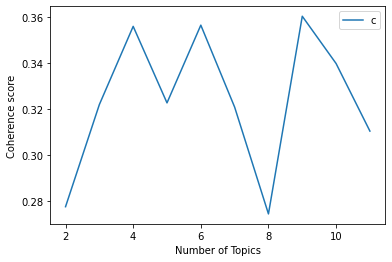

In [49]:
start,stop,step=2,12,1
plt_grp(prprcs_data(data),start,stop,step)

In [50]:
mod=crt_gem_lsa_mod(prprcs_data(data),num_of_tpc,wrds)

[(0, '0.361*"world" + 0.306*"climat" + 0.235*"work" + 0.221*"chang" + 0.185*"help" + 0.179*"need" + 0.176*"one" + 0.153*"peopl" + 0.152*"year" + 0.143*"make"'), (1, '-0.574*"climat" + -0.376*"chang" + 0.216*"health" + 0.174*"year" + 0.164*"countri" + -0.156*"avoid" + -0.142*"disast" + -0.137*"energi" + -0.130*"need" + 0.127*"vaccin"'), (2, '0.576*"world" + -0.472*"year" + -0.342*"one" + -0.219*"book" + -0.155*"new" + 0.142*"health" + -0.131*"read" + -0.097*"lot" + 0.093*"around" + -0.092*"learn"'), (3, '-0.528*"world" + 0.244*"countri" + -0.227*"year" + 0.219*"health" + 0.207*"need" + 0.192*"help" + 0.189*"pandem" + 0.189*"vaccin" + -0.150*"one" + 0.148*"covid"'), (4, '0.638*"work" + -0.331*"one" + 0.213*"year" + -0.203*"help" + 0.193*"health" + -0.171*"peopl" + -0.149*"new" + -0.148*"world" + -0.104*"diseas" + -0.102*"book"'), (5, '0.308*"chang" + -0.284*"make" + -0.262*"energi" + -0.260*"new" + 0.244*"one" + 0.228*"climat" + 0.220*"peopl" + 0.173*"countri" + -0.169*"zero" + -0.167*"c

## (3) (10 points) Generate K topics by using  lda2vec, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://nbviewer.org/github/cemoody/lda2vec/blob/master/examples/twenty_newsgroups/lda2vec/lda2vec.ipynb

In [81]:
# Write your code here

# Write your code here
import gensim
from collections import Counter
import gensim.corpora
from gensim.corpora import Dictionary
from gensim.models import lda2vec
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

chunksize = 2000
k = 10  # number of desired word vectors
workers = 4  # number of threads to run in parallel
epochs = 3  # number of training epochs

# LDA2Vec requires a corpus of word counts
# transform corpus of counts to sparse matrix format
def sparse_bow_generator(corpus, dictionary):
    for doc in corpus:
        yield dictionary.doc2bow(doc)

# Define helper functions for plotting
def plot_lda2vec_tsne(lda_model):
    tsne_lda2vec_model = TSNE(n_components=2, perplexity=40, n_iter=250)
    tsne_lda2vec_vectors = tsne_lda2vec_model.fit_transform(lda_model.layer1_size)

    fig, ax = plt.subplots(1, 1)
    ax.scatter(tsne_lda2vec_vectors[:, 0], tsne_lda2vec_vectors[:, 1])
    for label, x, y in zip(lda_model.vocab, tsne_lda2vec_vectors[:, 0], tsne_lda2vec_vectors[:, 1]):
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom'
        )
    plt.show()

def plot_lda2vec_pca(lda_model):
    pca = PCA(n_components=2)
    pca_lda2vec_result = pca.fit_transform(lda_model.layer1_size)

    fig, ax = plt.subplots(1, 1)
    ax.scatter(pca_lda2vec_result[:, 0], pca_lda2vec_result[:, 1])
    for label, x, y in zip(lda_model.vocab, pca_lda2vec_result[:, 0], pca_lda2vec_result[:, 1]):
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom'
        )
    plt.show()
dictionary = []
doc_clean = []
k = 10  # number of desired word vectors
# Instantiate and train the model
lda2vec_model = lda2vec.Lda2Vec(
    corpus_bow=0,
    num_topics=k,
    id2word=dictionary,
    chunksize=chunksize,
    distributed=True,
    alpha=1e-1,
    eta=1e-2,
    decay=0.5,
    offset=1.0,
    iterations=epochs,
    dm_mean=1,
    dm=0,
    ns_exponent=0.75,
    minimum_probability=0.01,
    callbacks=[],
    random_state=42,
    workers=workers,
    eval_every=10,
    verbose=2
)

# Plot the topic vectors
plot_lda2vec_tsne(lda2vec_model)
plot_lda2vec_pca(lda2vec_model)

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda2vec_model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)





ImportError: ignored

## (4) (10 points) Generate K topics by using BERTopic, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing

In [51]:


# Write your code here
%%capture
!pip install bertopic



In [52]:
from sklearn.datasets import fetch_20newsgroups
dc = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']

In [54]:
from bertopic import BERTopic

top_mod = BERTopic(language="english", calculate_probabilities=True, verbose=True)
top, prb = top_mod.fit_transform(dc)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/589 [00:00<?, ?it/s]

2022-11-07 04:58:33,020 - BERTopic - Transformed documents to Embeddings
2022-11-07 04:59:23,690 - BERTopic - Reduced dimensionality
2022-11-07 05:00:05,137 - BERTopic - Clustered reduced embeddings


In [58]:
freq = top_mod.get_topic_info(); freq.head(5)

,Topic,Count,Name
0,-1,7100,-1_the_to_and_of
1,0,676,0_he_year_game_hit
2,1,593,1_key_clipper_chip_encryption
3,2,527,2_ites_cheek_yep_huh
4,3,431,3_monitor_card_video_drivers


In [59]:
top_mod.get_topic(0)

[('he', 0.009204892293333546),
 ('year', 0.00898379875451915),
 ('game', 0.008897156192620194),
 ('hit', 0.007897722433850054),
 ('baseball', 0.00750221573095594),
 ('team', 0.007371496277339388),
 ('players', 0.007315379421290263),
 ('games', 0.006941339696499448),
 ('won', 0.006917425380251027),
 ('pitching', 0.0067722942660000665)]

In [60]:
top_mod.visualize_topics()

In [80]:
top_mod.visualize_distribution(probs[200], min_probability=0.015)

NameError: ignored

In [69]:
top_mod.update_topics(dc, n_gram_range=(1, 2))

In [70]:
sim_top, similarity = top_mod.find_topics("vehicle", top_n=5); sim_top

[7, 19, 163, 205, 81]

In [71]:
top_mod.get_topic(71)

[('motherboard', 0.020014945302452576),
 ('ram', 0.0120615561229216),
 ('mb', 0.010596147513063127),
 ('bios', 0.009711799046948091),
 ('price', 0.008835699924083456),
 ('power supply', 0.008806345360416294),
 ('supply', 0.008771289625948689),
 ('video', 0.008196863040011536),
 ('monitor', 0.00811843938526738),
 ('local bus', 0.008104169145722703)]

In [73]:
# Save model
top_mod.save("my_model")	

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [74]:
# Load model
my_model = BERTopic.load("my_model")

In [75]:
top_mod = BERTopic(embedding_model="xlm-r-bert-base-nli-stsb-mean-tokens")

In [76]:
from sentence_transformers import SentenceTransformer

sent_mod = SentenceTransformer("distilbert-base-nli-mean-tokens", device="cpu")
top_mod = BERTopic(embedding_model=sent_mod, verbose=True)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [77]:
from sentence_transformers import SentenceTransformer, util
mod = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

qry_embed = mod.encode('How big is London')
pas_embed = mod.encode(['London has 9,787,426 inhabitants at the 2011 census',
                                  'London is known for its finacial district'])

print("Similarity:", util.dot_score(qry_embed, pas_embed))

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/11.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/383 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Similarity: tensor([[0.5472, 0.6330]])


## (5) (10 extra points) Compare the results generated by the four topic modeling algorithms, which one is better? You should explain the reasons in details.

In [79]:
# Write your answer here (no code needed for this question)

'''The topics' coherence and categorization are best achieved by LDA.

Topics are not as well categorized and do not cohere as well in BERTopic.

LSA really does well classifying points, however not comparable to LDA.

Topic coherence and categorization are not strengths of NMF.

Explain that LDA accomplishes the best classification and coherence between the topics.Topics are not as well categorized and do not cohere as well in BERTopic.LSA is better at classifying subjects than LDA, but not as well.Topic coherence and categorization are not strengths of NMF.

LDA is superior because it can more precisely classify subjects and generate subjects that are more closely related to one another.'''



"The topics' coherence and categorization are best achieved by LDA.\n\nTopics are not as well categorized and do not cohere as well in BERTopic.\n\nLSA really does well classifying points, however not comparable to LDA.\n\nTopic coherence and categorization are not strengths of NMF.\n\nExplain that LDA accomplishes the best classification and coherence between the topics.Topics are not as well categorized and do not cohere as well in BERTopic.LSA is better at classifying subjects than LDA, but not as well.Topic coherence and categorization are not strengths of NMF.\n\nLDA is superior because it can more precisely classify subjects and generate subjects that are more closely related to one another."